In [35]:
import os
import copy

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
from itertools import islice
from rdkit import Chem
import linecache
from sklearn.metrics import roc_auc_score

from sklearn import metrics

path = "G:\\Dev\\CSIFingerID\\"
gnps_dir = "G:\\Dev\\Data\\GNPS For Family"
batch_file_dir = path + "ALL_GNPS_20181012_mini_batches"
output_file_dir = path + "all_sirius_output_minibatches"
sample_fingerprints_legend_path = path + "fingerprints.csv"
cdk_fingerprints_legend_path = path + "CDK_fingerprints_smarts.txt"
spectrum_smiles_dir = "G:\\Dev\\Data\\GNPS For Family"
mibig_smiles_file = "G:\\Dev\\Data\\smiles.tsv" 

In [10]:
spectrum_smiles = {}

for file in os.listdir(spectrum_smiles_dir):
    filepath = os.path.join(spectrum_smiles_dir, file)
    smiles = linecache.getline(filepath, 7)[8:-1]
    spectrum_smiles[file[:-3]] = smiles
    
with open(mibig_smiles_file, 'r') as f:
    for line in f:
        mol_id, smiles = line.split("\t")
        spectrum_smiles[mol_id] = smiles[:-1]

In [11]:
def file_has_fingerprint(file_content):
    return "fingerprints.csv" in file_content

def file_incomplete(file_content):
    return len(file_content) <= 2

def retrieve_fingerprint_file(formula, folder):
    content = os.listdir(folder)
    return next((filename for filename in content if formula in filename), None)

In [12]:
desc_list = []
count = 0
correct_fingerprint_count = 0

with open(sample_fingerprints_legend_path, 'r') as f:
    for line in f:
        rel_index, abs_index, desc = line.split("\t")
        if desc[:-1] != "description":
            desc_list.append(desc[:-1])

desc_list = desc_list[:154]
fingerprint_smarts = [entry.split(" ")[0] for entry in desc_list]

In [13]:
correct_folder_file = []
wrong_folder_file = []

for directory in os.listdir(output_file_dir):
    file_dir = os.path.join(output_file_dir, directory)
    files_in_output_dir = os.listdir(file_dir)
    if file_has_fingerprint(files_in_output_dir):
        mol = files_in_output_dir[1].split("_")[-1]
        mol_file = os.path.join(gnps_dir, mol + ".ms")
        if os.path.isfile(mol_file):
            with open(mol_file, 'r') as f:
                content = f.readlines()
                formula = content[1].split(" ")[-1][:-1]
        count += 1
        folder = "1_{0}_{1}".format(directory, mol)
        fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
        if retrieve_fingerprint_file(formula, fingerprints_file_dir):
            correct_folder_file.append((directory, mol, formula))
            correct_fingerprint_count += 1
        else:
            wrong_folder_file.append((directory, mol, formula))

In [14]:
correct_filenames = [entry[1] for entry in correct_folder_file if entry[1] in spectrum_smiles]
wrong_filenames = [entry[1] for entry in wrong_folder_file if entry[1] in spectrum_smiles]
print(len(correct_filenames))
print(len(wrong_filenames))

25
56


In [15]:
fingerprints_df = pd.DataFrame(0.0, index=correct_filenames, columns=range(len(desc_list)), dtype=float)
wrong_fingerprints_df = pd.DataFrame(0.0, index=wrong_filenames, columns=range(len(desc_list)), dtype=float)

print(len(desc_list))

154


In [16]:
for directory, mol, formula in correct_folder_file:
    file_dir = os.path.join(output_file_dir, directory)
    folder = "1_{0}_{1}".format(directory, mol)
    fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
    fingerprint_path = retrieve_fingerprint_file(formula, fingerprints_file_dir)
    full_fingerprint_path = os.path.join(fingerprints_file_dir, fingerprint_path)
    fingerprint_bits = np.loadtxt(full_fingerprint_path, dtype=np.double)
    relevant_fingerprint_bits = fingerprint_bits[:154]
    if mol in correct_filenames:
        fingerprints_df.loc[mol] = relevant_fingerprint_bits
    
print("Done")

Done


In [17]:
for directory, mol, formula in wrong_folder_file:
    file_dir = os.path.join(output_file_dir, directory)
    folder = "1_{0}_{1}".format(directory, mol)
    fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
    first_file = os.listdir(fingerprints_file_dir)[0]
    full_fingerprint_path = os.path.join(fingerprints_file_dir, first_file)
    fingerprint_bits = np.loadtxt(full_fingerprint_path, dtype=np.double)
    relevant_fingerprint_bits = fingerprint_bits[:154]
    if mol in wrong_filenames:
        wrong_fingerprints_df.loc[mol] = relevant_fingerprint_bits
    
print("Done")

Done


In [18]:
datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
gnps_for_family_datapath = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\For Family Q3\\GNPS Python Master\\Final Fingerprints.txt"
filtered_fingerprints_path = "G:\\Dev\\Data\\Filtered Mibig GNPS Links\\Filtered Mibig Fingerprints.tsv"
linked_fingerprints_path = "G:\\Dev\\Data\\Linked GNPS Fingerprints.tsv"
smiles_fingerprints_path = "G:\\Dev\\Data\\Fingerprint Bitmaps 2\\mibig_unique_smiles.txt"

families_path = "G:\\Dev\\Data\\Final Smiles Families.txt"
mibig_families_path = "G:\\Dev\\Data\\mibig_family.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"
families_names_path = "G:\\Dev\\Data\\Family Legend.txt"
num_samples = 5770
num_smiles_families_samples = 1368
val_fraction = 0.1
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1

In [19]:
# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_from_smarts_and_file(filenames):
    BITS = 154  # Total number of bits in fingerprint

    fingerprints = pd.DataFrame(0, index=filenames, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for filename in filenames:
        smiles = spectrum_smiles[filename]
        m = Chem.MolFromSmiles(smiles)
        for index, smarts in enumerate(fingerprint_smarts):
            patt = Chem.MolFromSmarts(smarts)
            fingerprints.at[filename, index] = int(m.HasSubstructMatch(patt))

    return fingerprints

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_from_smarts(path, number_of_rows=0):
    BITS = 154  # Total number of bits in fingerprint
    
    # number_of_rows to skip, e.g. headers
    fp_all = np.loadtxt(path, dtype="U105", skiprows=number_of_rows)  # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0])  # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index=fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for fp_id in fp_ids:
        smiles = spectrum_smiles[fp_id]
        m = Chem.MolFromSmiles(smiles)
        for index, smarts in enumerate(fingerprint_smarts):
            patt = Chem.MolFromSmarts(smarts)
            fingerprints.at[fp_id, index] = int(m.HasSubstructMatch(patt))

    return fingerprints

In [40]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
def baseline_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

In [21]:
def calc_peak_differences(spec):
    non_zero_peaks = list(np.where(spec>0)[0])
    peak_differences = [(abs(i-j), (spec[i]+spec[j]/2.0)) for i in non_zero_peaks for j in non_zero_peaks if i != j and j > i]
    
    return peak_differences

In [22]:
def load_shift_bins(intensities):
    shift_bins = np.zeros(intensities.shape, np.double)

    for index, spec in enumerate(intensities.values):
        peak_differences = calc_peak_differences(spec)
        for shift, average_intensity in peak_differences:
            shift_bins[index, shift - 1] += average_intensity

    return shift_bins

# Loads a master file containing peak intensities for all molecules.
# Each molecule's spectrum is added as a 1000 element row to a Pandas dataframe
# The dataframe is then converted into a numpy array for use as Keras Input.
# Include the option of adding additonal features to each molecule (mass_shifts variable)
def load_master_file(path, mass_shifts = 0, number_of_bins = 1000):
    MAX_MASS = 1000
    BIN_SIZE = 1
    NUM_FEATURES = mass_shifts
    mol_all = np.loadtxt(path, dtype="U25") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range((number_of_bins//BIN_SIZE)+NUM_FEATURES), dtype=float)
    
    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], float(row[1])-1] = float(row[2])
    
    return intensities

def normalise(X):
    for i,row in enumerate(X):
        tot = row.sum()
        if tot > 0:
            for j in range(len(row)):
                X[i,j] = (1.0*row[j])/tot
    return X

In [33]:
# Takes a actual and predicted values and computes the area under the Roc curve for each.
# For each, also calculates AUC when the actual values are scrambled.
# Return two numpy arrays: one containing AUC metrics for all , one containing each permutation's
# AUC scores for each.
def compute_auc(bits, true, pred, num_samples=0, permutations=500):
    val_start_index = 0
    if num_samples > 0:
        val_start_index = int(num_samples - (num_samples * val_fraction) - 1)  # Index where validation samples begin.

    num_permutations = permutations  # Number of permutations to compute AUC scores for.

    # Create structured array to hold statistics for each.
    dtype = [('fp_id', int), ('nonzeros', int), ('auc', float), ('auc_percent', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    # Create array to hold permutation AUC scores for plotting.
    perm_scores = np.zeros((bits, num_permutations))

    for fp_id in range(true.shape[1]):  # For every substructure
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id])  # Count number of nonzero values
        if 0 < nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[val_start_index:, fp_id]
            fp_pred = pred[val_start_index:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Compute AUC scores for permutations and compare to actual.
            counter = 0
            for i in range(num_permutations):
                permutation = np.random.permutation(fp_true)
                perm_score = metrics.roc_auc_score(permutation, fp_pred)
                perm_scores[fp_id, i] = perm_score
                # Count how many permutations have a higer AUC score than actual data.
                if perm_score >= score:
                    counter = counter + 1
            # Calculate % of scrambled values with higher AUC score than actual AUC
            percentage = (counter / num_permutations) * 100
            # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = fp_id, nonzero_vals, score, percentage
        else:
            mol_stats[fp_id] = (fp_id, nonzero_vals, 0, 100)

    # Permutations take a while, print statement to say when finished.
    print("Done")
    return mol_stats, perm_scores


# Given the AUC statistics derived from two separate models, it comapres the two models' performance
# Creates a bar chart comparing substructures above an AUC threshold and draws boxplots for each model's best and worst
# performing substructures.
# Usually compares an experimental model's AUC to a baseline (e.g. the basic fingerprint encoder)
def evaluate(base_stats, base_perm_scores, exp_stats, exp_perm_scores, names):
    # Sort molecules in ascending order of baseline AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((base_stats['auc'] > 0.5))
    abnormal_auc = np.where((base_stats['auc']) < 0.5)
    ordered_base = np.sort(base_stats[normal_auc], order='auc', axis=0)[::-1]

    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_base[:30]
    sample_fps = np.append(sample_fps, ordered_base[-5:])

    # Plot number of substructures with AUC scores above 0.7 and above 0.5 for both data sets
    base_above_07 = len(np.where((base_stats['auc'] >= 0.7))[0])
    exp_above_07 = len(np.where((exp_stats['auc'] >= 0.7))[0])
    base_above_05 = len(np.where((base_stats['auc'] >= 0.5))[0])
    exp_above_05 = len(np.where((exp_stats['auc'] >= 0.5))[0])

    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.5
    ax.bar(index, (base_above_05, base_above_07), bar_width, alpha=opacity, color='b', label='Baseline')
    ax.bar(index + bar_width, (exp_above_05, exp_above_07), bar_width, alpha=opacity, color='r', label='Experiment')

    ax.set_xlabel('AUC Threshold')
    ax.set_ylabel('Number of Substructures')
    ax.set_title('AUC Score Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Above 0.5', 'Above 0.7'))
    ax.legend()

    plt.show()

    # Boxplots of sample substructures for both data sets
    boxplots(base_stats, base_perm_scores, sample_fps, names)
    boxplots(exp_stats, exp_perm_scores, sample_fps, names)
    tandem_boxplots(base_stats, base_perm_scores, exp_stats, sample_fps, names)

    # Sort molecules in ascending order of experimental AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((exp_stats['auc'] > 0.5))
    abnormal_auc = np.where((exp_stats['auc']) < 0.5)
    ordered_exp = np.sort(exp_stats[normal_auc], order='auc', axis=0)[::-1]

    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_exp[:30]
    sample_fps = np.append(sample_fps, ordered_exp[-5:])

    boxplots(base_stats, base_perm_scores, sample_fps, names)
    boxplots(exp_stats, exp_perm_scores, sample_fps, names)
    tandem_boxplots(base_stats, exp_perm_scores, exp_stats, sample_fps, names)

In [23]:
spectra = load_master_file(path=datapath)
fingerprints = load_fingerprints_from_smarts(fingerprints_path, number_of_rows=1)
N,M = spectra.shape
shuffle_order = np.random.permutation(N)
print(N,M)
print("Done")

6538 1000
Done


In [42]:
# Example of how to run a fingerprint encoder

# Training network 1 (exclude links)
epochs = 100
extra_epochs = 100
x_train_spectra = np.log(spectra+1)
x_train_fingerprints = fingerprints.values
shift_bins = load_shift_bins(x_train_spectra)

x_shifts = normalise(shift_bins)
print(x_shifts.shape)

x_train_fingerprints = fingerprints.values
mod = baseline_model(x_shifts, x_train_fingerprints)
mod.fit(x_shifts[shuffle_order,:],x_train_fingerprints[shuffle_order],epochs=epochs,validation_split=0.2,verbose=0)
mod.fit(x_shifts[shuffle_order,:],x_train_fingerprints[shuffle_order],epochs=extra_epochs,validation_split=0.2,verbose=0)
print("Done")

(6538, 1000)
Done


Compare when CSI got it right to our model

(25, 1000)
Done
Done


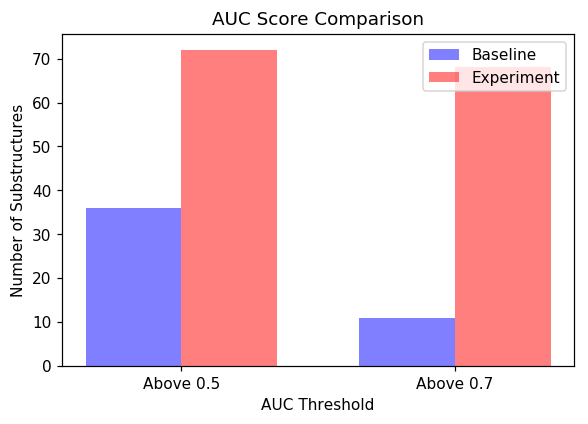

NameError: name 'boxplots' is not defined

In [43]:
correct_spectra = spectra[spectra.index.isin(correct_filenames)]
shift_bins = load_shift_bins(correct_spectra)

x_shifts = normalise(shift_bins)
print(x_shifts.shape)

predicted = mod.predict(x_shifts)
true_fingerprints_for_correct_file = load_fingerprints_from_smarts_and_file(correct_filenames)

baseline_stats, baseline_perm_scores = compute_auc(154, true_fingerprints_for_correct_file.values, predicted)
exp_stats, exp_perm_scores = compute_auc(154, true_fingerprints_for_correct_file.values, fingerprints_df.values)

evaluate(baseline_stats, baseline_perm_scores, exp_stats, exp_perm_scores, range(154))

Compare when CSI got it wrong to our model

(56, 1000)
Done
Done


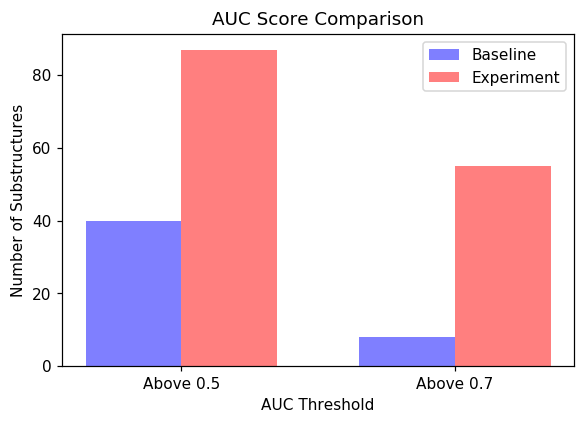

NameError: name 'boxplots' is not defined

In [44]:
wrong_spectra = spectra[spectra.index.isin(wrong_filenames)]
shift_bins = load_shift_bins(wrong_spectra)

x_shifts = normalise(shift_bins)
print(x_shifts.shape)

predicted = mod.predict(x_shifts)
true_fingerprints_for_wrong_file = load_fingerprints_from_smarts_and_file(wrong_filenames)

baseline_stats, baseline_perm_scores = compute_auc(154, true_fingerprints_for_wrong_file.values, predicted)
exp_stats, exp_perm_scores = compute_auc(154, true_fingerprints_for_wrong_file.values, wrong_fingerprints_df.values)

evaluate(baseline_stats, baseline_perm_scores, exp_stats, exp_perm_scores, range(154))

Compare when CSI got the fingerprints (both correct and wrong) to our model

(81, 1000)
Done
Done


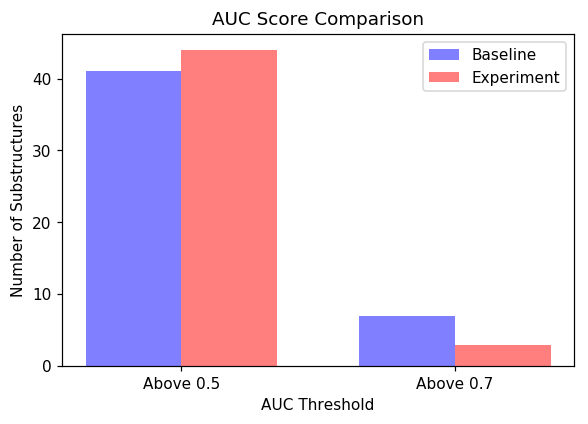

NameError: name 'boxplots' is not defined

In [45]:
combined_spectra = spectra[spectra.index.isin(wrong_filenames + correct_filenames)]
shift_bins = load_shift_bins(combined_spectra)

x_shifts = normalise(shift_bins)
print(x_shifts.shape)

predicted = mod.predict(x_shifts)
true_fingerprints_for_combined_file = load_fingerprints_from_smarts_and_file(wrong_filenames + correct_filenames)

baseline_stats, baseline_perm_scores = compute_auc(154, true_fingerprints_for_combined_file.values, predicted)

combined_fingerprints_df = pd.concat([fingerprints_df, wrong_fingerprints_df])
exp_stats, exp_perm_scores = compute_auc(154, true_fingerprints_for_combined_file.values, combined_fingerprints_df.values)

evaluate(baseline_stats, baseline_perm_scores, exp_stats, exp_perm_scores, range(154))